# Downloading Light Curves from MAST

This notebook demonstrates how to use `mono_cbp.utils.catalogue_to_lc_files` to automatically download TESS light curve data in the format that `mono-cbp` is expecting for targets in your input catalogue.

## What this function does:

1. Downloads TESS-SPOC light curves from MAST for each target and sector
2. Applies contamination corrections (using CROWDSAP and FLFRCSAP)
3. Bins data to 30-minute cadence
4. Calculates the orbital phase of the binary at each cadence using `period` and `bjd0` from catalogue
5. Saves as text files in the standard `mono-cbp` format

## Output format:

Files are saved as `TIC_{id}_{sector}.txt` with columns:
- TIME (BJD - 2457000)
- FLUX (normalised)
- FLUX_ERR (normalised)
- PHASE (orbital phase of the binary)

In [1]:
import logging
from mono_cbp.utils import load_catalogue, get_row, catalogue_to_lc_files, setup_logging

# Set up logging to see progress
# This configures the root 'mono_cbp' logger which all module loggers inherit from
logger = setup_logging(level=logging.INFO)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Example 1: Download light curves for a single target

This is useful when you want to test the download process or work with a specific target.

**Note about logging:** You should see logging messages for:
- Files that already exist (will skip re-downloading)
- Successfully saved files 
- Warnings when data is not available
- Errors during downloads

If files already exist, you'll see "already exists. Skipping download." messages in the output.

In [2]:
# Load the TEBC catalogue (TEBC=True is required for TEBC format catalogues)
cat = load_catalogue('../catalogues/TEBC_morph_05_P_7.csv', TEBC=True)

# Get a specific target (e.g. TIC 271548206)
tic_id = 271548206
row = get_row(cat, tic_id)

# Download light curves for this target only
catalogue_to_lc_files(row, output_path='../data')

2025-12-09 03:04:48 - mono_cbp.utils.data - INFO - Loaded catalogue with 592 targets from ../catalogues/TEBC_morph_05_P_7.csv
2025-12-09 03:04:50 - mono_cbp.utils.data - INFO - Saved light curve data to ../data/TIC_271548206_14.txt
2025-12-09 03:04:50 - mono_cbp.utils.data - INFO - Saved light curve data to ../data/TIC_271548206_15.txt


## Example 2: Download light curves for multiple specific targets

You can also download all light curves from the input catalogue.

In [3]:
# Select first 5 targets from the catalogue
subset = cat.head(5)

print(f"Downloading light curves for {len(subset)} targets:")
print(subset[['tess_id', 'sectors']].to_string(index=False))

# Uncomment to download the light curves for these targets
# catalogue_to_lc_files(subset, output_path='../data')

  tess_id                                                  sectors
363326796                                                        9
146530594                                                  9,10,36
349518145                            1,2,3,4,5,6,7,8,9,10,11,12,13
398850090                                                       10
300293197 1,2,3,4,5,6,7,8,9,10,11,12,13,28,29,30,31,32,33,34,35,36


## Example 3: Download light curves for all targets in the catalogue

**Warning:** This will download light curves for ALL targets in the catalogue, which may take a long time and require significant storage space.

The function automatically skips files that already exist, so you can safely interrupt and resume.

In [4]:
# Load catalogue
cat = load_catalogue('../catalogues/TEBC_morph_05_P_7.csv', TEBC=True)

print("\nThis will download light curves for all targets.")
print("The process will:")
print("  - Skip files that already exist")
print("  - Log warnings for targets without TESS-SPOC data")
print("  - Log errors for failed downloads")

# Uncomment the line below to run the full download
# catalogue_to_lc_files(cat, output_path='../test_data')

2025-12-09 03:04:50 - mono_cbp.utils.data - INFO - Loaded catalogue with 592 targets from ../catalogues/TEBC_morph_05_P_7.csv



This will download light curves for all targets.
The process will:
  - Skip files that already exist
  - Log warnings for targets without TESS-SPOC data
  - Log errors for failed downloads


## Example 4: Verify downloaded files

Check what files were downloaded and load one to inspect the format.

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt

# List all downloaded light curve files
data_dir = '../data'
if os.path.exists(data_dir):
    lc_files = [f for f in os.listdir(data_dir) if f.endswith('.txt') and f.startswith('TIC_')]
    print(f"Found {len(lc_files)} light curve files:")
    for f in sorted(lc_files)[:10]:  # Show first 10
        print(f"  {f}")
    if len(lc_files) > 10:
        print(f"  ... and {len(lc_files) - 10} more")
else:
    print(f"Directory {data_dir} does not exist yet. Run one of the examples above first.")

Found 2 light curve files:
  TIC_271548206_14.txt
  TIC_271548206_15.txt


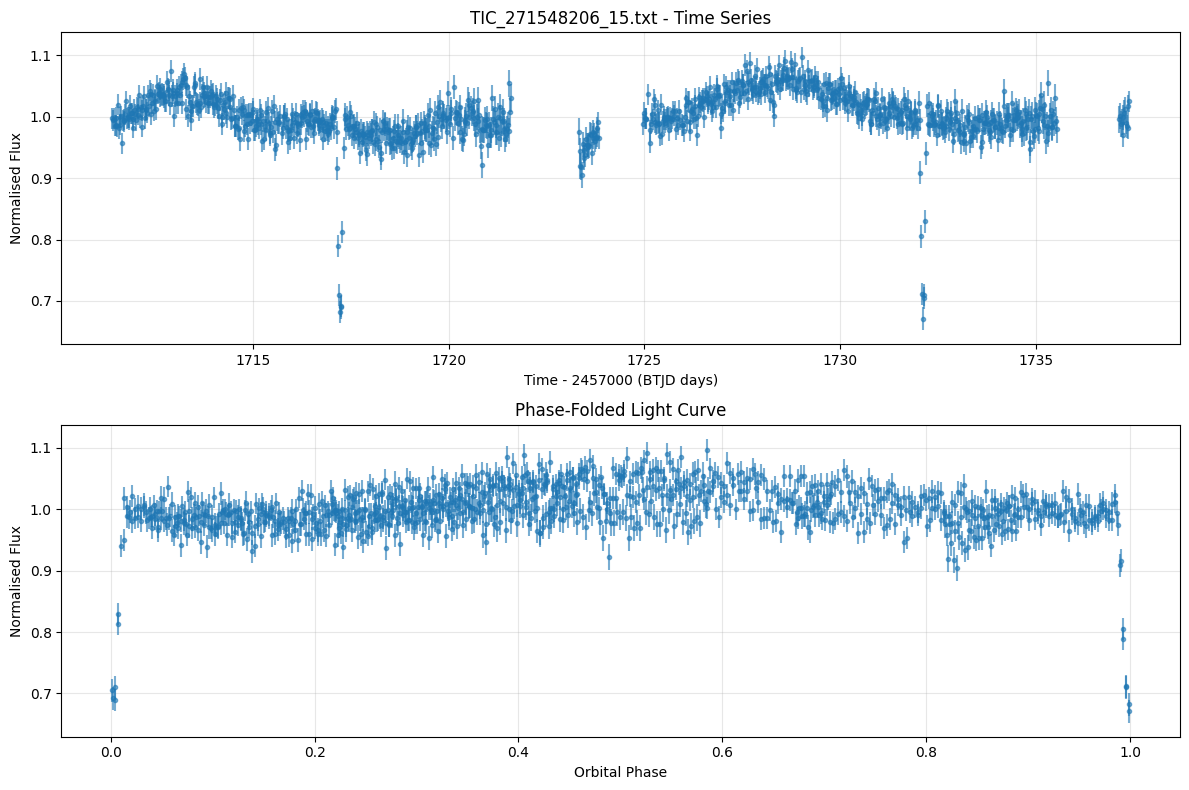

In [6]:
# Load and inspect a light curve file
if os.path.exists(data_dir) and len(lc_files) > 0:
    # Load the first available file
    example_file = os.path.join(data_dir, lc_files[0])
    data = np.loadtxt(example_file)
    
    time = data[:, 0]
    flux = data[:, 1]
    flux_err = data[:, 2]
    phase = data[:, 3]
    
    # Plot the light curve
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Time series
    ax1.errorbar(time, flux, yerr=flux_err, fmt='o', markersize=3, alpha=0.6)
    ax1.set_xlabel('Time - 2457000 (BTJD days)')
    ax1.set_ylabel('Normalised Flux')
    ax1.set_title(f'{lc_files[0]} - Time Series')
    ax1.grid(alpha=0.3)
    
    # Phase-folded
    ax2.errorbar(phase, flux, yerr=flux_err, fmt='o', markersize=3, alpha=0.6)
    ax2.set_xlabel('Orbital Phase')
    ax2.set_ylabel('Normalised Flux')
    ax2.set_title('Phase-Folded Light Curve')
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No light curve files found. Run one of the download examples first.")

## Important Notes

### TEBC Catalogues
- Always use `TEBC=True` when loading the TESS Eclipsing Binary Catalogue (i.e., contains `*_2g` and `*_pf` values for eclipse parameters)

### File Handling
- Files are automatically skipped if they already exist
- Safe to interrupt and resume downloads
- Check logs for warnings about missing data or failed downloads

### Data Processing
- Contamination corrections are automatically applied using the CROWDSAP and FLFRCSAP values (see the [TESS documentation](https://heasarc.gsfc.nasa.gov/docs/tess/UnderstandingCrowdingv2.html))
- Data is automatically binned to 30-minute cadence (if cadence is faster than this)
- Flux is median normalised

### Common Issues
1. **"No TESS-SPOC light curve found"**: Some targets may not have TESS-SPOC data available
2. **"Download failed from MAST"**: Network issues or MAST server problems
3. **Missing sectors**: Some sectors listed in the catalogue may not have data on MAST

### Next Steps
Once you have downloaded your light curves, you can use them with the mono-cbp pipeline:
- `01_complete_pipeline.ipynb` - Run the full pipeline
- `02_eclipse_masking.ipynb` - Mask eclipses
- `03_transit_finding.ipynb` - Find threshold crossing events (TCEs)
- `04_model_comparison.ipynb` - Perform Bayesian model comparison
- `05_injection_retrieval.ipynb` - Determine detection sensitivity for different transit morphologies for your search